In [13]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, List
import operator
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [3]:
load_dotenv()

True

In [4]:
model=ChatOpenAI(model='gpt-4o-mini')

In [5]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedback for essay')
    score: int = Field(description='Score out of 10',ge=0,le=10)
    

In [8]:
structured_model=model.with_structured_output(EvaluationSchema)

In [27]:
essay = """The Role of Technology in Shaping the Future

In the contemporary world, technology has become the cornerstone of human progress, influencing almost every aspect of our lives. From the way we communicate to the way we work, travel, and even think, the digital revolution has redefined the boundaries of possibility. The question is no longer whether technology shapes the future, but how wisely we harness its power.

One of the most profound contributions of technology lies in its ability to connect people across geographical and cultural divides. The internet and social media platforms have transformed the globe into a "digital village," where ideas and information travel faster than ever before. This interconnectedness fosters collaboration, innovation, and cultural exchange, making the world more interdependent than at any other point in history.

Equally important is the role of technology in healthcare. Breakthroughs in artificial intelligence, biotechnology, and robotics are not only prolonging human life but also enhancing its quality. Diseases once considered fatal are now manageable, and precision medicine promises tailored treatments that meet the unique needs of individuals. Technology, therefore, stands as a beacon of hope in the quest for healthier and more fulfilling lives.

However, it would be naïve to view technology as a purely benevolent force. Its misuse has led to cybercrime, data breaches, and ethical dilemmas surrounding privacy. Moreover, automation and artificial intelligence, while enhancing efficiency, also threaten traditional employment structures, leaving millions anxious about their livelihoods. Thus, the challenge before humanity is not the advancement of technology itself, but the wisdom with which we choose to employ it.

In conclusion, technology is both a gift and a responsibility. It holds the potential to create unprecedented opportunities, but it also demands thoughtful regulation and ethical application. As we move forward, it is imperative to strike a delicate balance—embracing innovation while safeguarding human values. The future will not be determined by technology alone, but by our collective ability to ensure that it serves humanity rather than dominates it."""

In [38]:
essay2="""Technology in the Future

Technology is very important in today’s world and it is everywhere. People are using it for many things like phone, internet, computer, and it is always increasing. Technology makes life easy but sometimes also it makes problems.

One good thing of technology is that it helps people to talk. Like if someone is far away, you can call them or message them. Social media is also there and people use it every day. This is making life fast and simple.

Another important thing is in health. Doctors use machines and computers. There are new medicines and robots in hospitals. This can save people and make them live long.

But technology also has bad things. People spend too much time on mobile and internet. It also make people lazy. Many jobs are going because machines can do them now. So people are losing work and it is a big problem for the future.

In conclusion, technology is good and bad. We should use it in right way. If we use too much it is bad but if we use it less it is not useful. So it is important to balance."""

In [29]:
prompt=f"Evaluate the language quality of the following eassy and provide a feedback and assign the score between 0-10"
structured_model.invoke(prompt)

EvaluationSchema(feedback='The essay demonstrates a good command of language, with varied vocabulary and sentence structures that enhance clarity and engagement. However, there are some grammatical errors and awkward phrasings that detract from the overall quality. The organization of ideas could be improved, as transitioning between paragraphs feels abrupt at times. Additionally, more concrete examples would strengthen the arguments presented. Overall, the essay has a solid foundation but requires refinement in certain areas to enhance its effectiveness.', score=6)

In [30]:
class UPSCState(TypedDict):

    essay:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[list[int],operator.add]
    avg_score:float

In [31]:
def evaluate_language(state:UPSCState):
    
    prompt=f"Evaluate the language quality of the following eassy and provide a feedback and assign the score out of 10 \n {state['essay']}"
    output=structured_model.invoke(prompt)

    return {'language_feedback':output.feedback, 'individual_scores' : [output.score]}


In [32]:
def evaluate_analysis(state:UPSCState):
    
    prompt=f"Evaluate the depth of analysis of the following eassy and provide a feedback and assign the score out of 10 \n {state['essay']}"
    output=structured_model.invoke(prompt)

    return {'analysis_feedback':output.feedback, 'individual_scores' : [output.score]}


In [33]:
def evaluate_thought(state:UPSCState):
    
    prompt=f"Evaluate the clarity of thought of the following eassy and provide a feedback and assign the score out of 10 \n {state['essay']}"
    output=structured_model.invoke(prompt)

    return {'clarity_feedback':output.feedback, 'individual_scores' : [output.score]}


In [34]:
def final_evaluation(state:UPSCState):

    #summary feedback
    
    prompt=f"Based on the following feedbacks create a summarized feedback \n language feedback - {state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity of thought feedback - {state['clarity_feedback']}"
    overall_feedback=model.invoke(prompt).content

    #avg feedback
    avg_score=sum(state['individual_scores'])/len(state['individual_scores'])

    return {"overall_feedback":overall_feedback,'avg_score':avg_score}

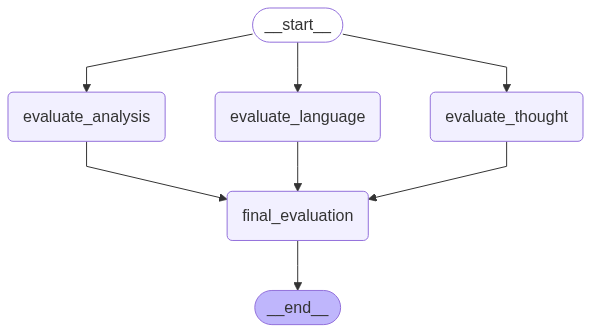

In [35]:
graph=StateGraph(UPSCState)

#nodes 
graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thought',evaluate_thought)
graph.add_node('final_evaluation',final_evaluation)


# edges
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')
graph.add_edge('final_evaluation',END)


graph.compile()

In [36]:
workflow=graph.compile()

In [37]:
initial_state={
    'essay':essay
}
workflow.invoke(initial_state)

{'essay': 'The Role of Technology in Shaping the Future\n\nIn the contemporary world, technology has become the cornerstone of human progress, influencing almost every aspect of our lives. From the way we communicate to the way we work, travel, and even think, the digital revolution has redefined the boundaries of possibility. The question is no longer whether technology shapes the future, but how wisely we harness its power.\n\nOne of the most profound contributions of technology lies in its ability to connect people across geographical and cultural divides. The internet and social media platforms have transformed the globe into a "digital village," where ideas and information travel faster than ever before. This interconnectedness fosters collaboration, innovation, and cultural exchange, making the world more interdependent than at any other point in history.\n\nEqually important is the role of technology in healthcare. Breakthroughs in artificial intelligence, biotechnology, and rob

In [41]:
essay3="""In the twenty-first century, technology has transcended its role as a mere tool and emerged as the architect of human progress. It is no exaggeration to claim that technology shapes not only the way we live but also the way we imagine the future. From communication and healthcare to education and governance, technological innovations have redefined possibilities. The challenge, however, is to ensure that this extraordinary force remains an instrument of empowerment rather than a source of division.

One of the most transformative impacts of technology lies in communication. The internet has effectively turned the world into what Marshall McLuhan once envisioned as a “global village.” Platforms such as X (formerly Twitter) and WhatsApp have allowed instantaneous connection, enabling information to flow across continents within seconds. For instance, during natural disasters, real-time updates on social media have saved countless lives by facilitating rapid responses. Yet, this very immediacy can also fuel misinformation, highlighting the double-edged nature of digital interconnectedness.

Equally significant are the breakthroughs in healthcare. Artificial intelligence is revolutionizing medical diagnostics, with algorithms now capable of detecting diseases like cancer at earlier stages than human doctors. In addition, innovations in biotechnology and robotics are enabling precision surgeries and personalized treatments, offering hope to millions. The COVID-19 pandemic demonstrated how technology, through vaccine development and digital telemedicine platforms, can act as humanity’s lifeline during crises.

Nevertheless, technology is not without its perils. Automation and artificial intelligence threaten to displace millions of workers, especially in manufacturing and transport. Similarly, data breaches and cyberattacks expose individuals and nations to unprecedented risks. The rise of addictive digital platforms has also exacerbated mental health challenges, particularly among the youth. These concerns underscore the urgency of adopting ethical frameworks to govern innovation.

Looking ahead, the solution lies not in curbing technological growth but in directing it responsibly. Governments must craft regulations that safeguard privacy while encouraging innovation. Educational systems should prioritize digital literacy so that future generations can critically navigate online spaces. Equally, corporations must embrace ethical AI practices that place human welfare above profit. By implementing such measures, society can ensure that technology remains a servant of humanity rather than its master.

In conclusion, technology is neither inherently good nor bad; its value depends on the choices we make. When harnessed with foresight and responsibility, it can bridge divides, cure diseases, and uplift societies. When misused or left unchecked, it can widen inequalities and erode trust. The future, therefore, is not dictated by machines or algorithms but by human wisdom in guiding their use. If balanced prudence accompanies innovation, technology will indeed stand as the architect of a brighter tomorrow.
"""

In [42]:
initial_state={
    'essay':essay2
}
workflow.invoke(initial_state)

{'essay': 'Technology in the Future\n\nTechnology is very important in today’s world and it is everywhere. People are using it for many things like phone, internet, computer, and it is always increasing. Technology makes life easy but sometimes also it makes problems.\n\nOne good thing of technology is that it helps people to talk. Like if someone is far away, you can call them or message them. Social media is also there and people use it every day. This is making life fast and simple.\n\nAnother important thing is in health. Doctors use machines and computers. There are new medicines and robots in hospitals. This can save people and make them live long.\n\nBut technology also has bad things. People spend too much time on mobile and internet. It also make people lazy. Many jobs are going because machines can do them now. So people are losing work and it is a big problem for the future.\n\nIn conclusion, technology is good and bad. We should use it in right way. If we use too much it is

In [43]:
initial_state={
    'essay':essay3
}
workflow.invoke(initial_state)

{'essay': 'In the twenty-first century, technology has transcended its role as a mere tool and emerged as the architect of human progress. It is no exaggeration to claim that technology shapes not only the way we live but also the way we imagine the future. From communication and healthcare to education and governance, technological innovations have redefined possibilities. The challenge, however, is to ensure that this extraordinary force remains an instrument of empowerment rather than a source of division.\n\nOne of the most transformative impacts of technology lies in communication. The internet has effectively turned the world into what Marshall McLuhan once envisioned as a “global village.” Platforms such as X (formerly Twitter) and WhatsApp have allowed instantaneous connection, enabling information to flow across continents within seconds. For instance, during natural disasters, real-time updates on social media have saved countless lives by facilitating rapid responses. Yet, t

In [44]:
essay4="""In the twenty-first century, technology has transcended its role as a mere tool and emerged as the architect of human progress. It not only shapes the way we live but also redefines how we envision the future. From communication and healthcare to education and governance, technological innovations have expanded the boundaries of possibility. The challenge, however, is ensuring that this extraordinary force remains an instrument of empowerment rather than a source of inequality.

One of the most transformative impacts of technology lies in communication. The internet has effectively turned the world into what Marshall McLuhan famously called a “global village.” Platforms such as WhatsApp and X (formerly Twitter) allow instantaneous connection, enabling information to cross continents within seconds. For instance, during natural disasters, real-time updates on social media have saved lives by directing aid and raising awareness. Yet this immediacy also spreads misinformation at an alarming rate, reminding us of the double-edged nature of digital interconnectedness.

Equally significant are the breakthroughs in healthcare. Artificial intelligence now detects diseases like cancer at earlier stages than human doctors, while biotechnology and robotics enable precision surgeries and personalized treatments. The World Health Organization’s Global Strategy on Digital Health illustrates how institutions can guide these innovations responsibly, ensuring global access while reducing inequalities. The COVID-19 pandemic further demonstrated technology’s lifesaving power, as rapid vaccine development and telemedicine platforms became lifelines in times of crisis.

Beyond healthcare and communication, technology is reshaping education and the environment. Online learning platforms like Coursera and Khan Academy have democratized access to knowledge, allowing students in remote villages to access resources once available only in elite institutions. In environmental sustainability, innovations in renewable energy and smart agriculture are helping combat climate change. At the same time, however, surveillance technologies and facial recognition raise ethical concerns, particularly in authoritarian regimes where they threaten civil liberties.

Despite its benefits, technology also has undeniable risks. Automation and artificial intelligence threaten to displace millions of workers, especially in manufacturing and logistics. Some argue that this shift will irreversibly destroy jobs and deepen inequality. Yet history suggests that while technology eliminates certain roles, it also creates new industries—from app development to renewable energy engineering. The challenge lies in preparing workers for this transition through reskilling and education.

Looking ahead, the solution is not to slow technological progress but to regulate and direct it responsibly. Governments must craft policies like the European Union’s General Data Protection Regulation (GDPR), which balances innovation with privacy protection. The United States’ AI Bill of Rights is another step toward ethical AI, ensuring that human dignity remains central. Educational systems must prioritize digital literacy, equipping future generations to critically navigate online spaces. Corporations, too, must embrace ethical frameworks that place human welfare above short-term profit.

In conclusion, technology is neither inherently good nor bad; its value depends on the choices we make. When harnessed with foresight and responsibility, it can bridge divides, cure diseases, and safeguard the planet. When misused or left unchecked, it can widen inequalities and erode trust. Ultimately, technology will not define humanity’s destiny—our wisdom in guiding it will. If balanced prudence accompanies innovation, technology will indeed stand as the architect of a brighter tomorrow."""

In [45]:
initial_state={
    'essay':essay4
}
workflow.invoke(initial_state)

{'essay': 'In the twenty-first century, technology has transcended its role as a mere tool and emerged as the architect of human progress. It not only shapes the way we live but also redefines how we envision the future. From communication and healthcare to education and governance, technological innovations have expanded the boundaries of possibility. The challenge, however, is ensuring that this extraordinary force remains an instrument of empowerment rather than a source of inequality.\n\nOne of the most transformative impacts of technology lies in communication. The internet has effectively turned the world into what Marshall McLuhan famously called a “global village.” Platforms such as WhatsApp and X (formerly Twitter) allow instantaneous connection, enabling information to cross continents within seconds. For instance, during natural disasters, real-time updates on social media have saved lives by directing aid and raising awareness. Yet this immediacy also spreads misinformation

In [46]:
essay5="""Technology is no longer just a tool; it has become the driving force of modern progress. It shapes how we live, work, and imagine the future. From communication and healthcare to education and governance, innovation expands possibilities. The central challenge is not whether technology will grow, but whether society can guide it responsibly.

One of the most visible impacts of technology is communication. The internet has turned the world into what Marshall McLuhan described as a “global village.” Platforms like WhatsApp and X (formerly Twitter) enable instant information exchange. For example, during the 2023 Turkey–Syria earthquake, real-time updates on social media helped direct rescue operations and mobilize aid within hours. Yet, the same speed that spreads life-saving information also fuels misinformation, showing the double-edged nature of digital connectivity.

Healthcare has also been transformed. Artificial intelligence now assists in early cancer detection with accuracy rates exceeding 90%, according to a 2020 study in Nature Medicine. Robotics enable precision surgeries, while telemedicine expanded rapidly during the COVID-19 pandemic, ensuring millions could access doctors remotely. The World Health Organization’s Global Strategy on Digital Health demonstrates how policy can support innovation while ensuring equitable access.

Education is another field where technology is narrowing gaps. Platforms like Khan Academy and Coursera bring high-quality lessons to students in remote areas. During the pandemic, UNESCO reported that online learning helped 1.5 billion students continue their education when schools were closed. At the same time, the digital divide persists: nearly 2.7 billion people worldwide remain offline, highlighting inequality in access.

However, technology carries risks. The World Economic Forum predicts that automation could displace 85 million jobs by 2025, particularly in manufacturing and logistics. Critics argue this will deepen inequality. Yet history shows new industries often emerge alongside disruption, from renewable energy to app development. Reskilling and lifelong learning are therefore essential to turn displacement into opportunity.

Ethical concerns are equally urgent. Surveillance technologies, such as China’s widespread use of facial recognition, raise serious questions about privacy and freedom. In response, governments have introduced frameworks like the European Union’s General Data Protection Regulation (GDPR), which enforces strict rules on data use, and the United States’ AI Bill of Rights, which emphasizes fairness and accountability. These examples show how regulation can keep innovation aligned with human values.

In conclusion, technology is both a promise and a responsibility. It can connect communities, cure diseases, and democratize knowledge, but it can also deepen inequality and threaten freedoms if left unchecked. The path forward lies in combining innovation with accountability: enforcing privacy laws, investing in digital literacy, and preparing workers for new industries. Ultimately, technology will not define humanity’s destiny—our wisdom in governing it will."""

In [47]:
initial_state={
    'essay':essay5
}
workflow.invoke(initial_state)

{'essay': 'Technology is no longer just a tool; it has become the driving force of modern progress. It shapes how we live, work, and imagine the future. From communication and healthcare to education and governance, innovation expands possibilities. The central challenge is not whether technology will grow, but whether society can guide it responsibly.\n\nOne of the most visible impacts of technology is communication. The internet has turned the world into what Marshall McLuhan described as a “global village.” Platforms like WhatsApp and X (formerly Twitter) enable instant information exchange. For example, during the 2023 Turkey–Syria earthquake, real-time updates on social media helped direct rescue operations and mobilize aid within hours. Yet, the same speed that spreads life-saving information also fuels misinformation, showing the double-edged nature of digital connectivity.\n\nHealthcare has also been transformed. Artificial intelligence now assists in early cancer detection wit

In [48]:
poor_essay="""Technology is very important and people use it every day. It is in phone, computer, internet and so many things. Technology is good but also bad sometimes. People like it because it makes life easy but also it makes people lazy.

Technology help in communication. We can talk with people far away by mobile or internet. This is good but also people spend too much time on phone and not outside. Technology also help in health because doctors use machine and computers. But sometimes machine also fail so it is not always good.

Technology is also problem for jobs. Many people lose job because machine do work fast and cheap. This make people sad. Also student use internet too much and they not study well. It is making problem in society.

In conclusion, technology is good and bad. It help people but also create problem. We should use technology carefully. If use too much then it is bad but if no use then it is not good also."""

In [49]:
initial_state={
    'essay':poor_essay
}
workflow.invoke(initial_state)

{'essay': 'Technology is very important and people use it every day. It is in phone, computer, internet and so many things. Technology is good but also bad sometimes. People like it because it makes life easy but also it makes people lazy.\n\nTechnology help in communication. We can talk with people far away by mobile or internet. This is good but also people spend too much time on phone and not outside. Technology also help in health because doctors use machine and computers. But sometimes machine also fail so it is not always good.\n\nTechnology is also problem for jobs. Many people lose job because machine do work fast and cheap. This make people sad. Also student use internet too much and they not study well. It is making problem in society.\n\nIn conclusion, technology is good and bad. It help people but also create problem. We should use technology carefully. If use too much then it is bad but if no use then it is not good also.',
 'language_feedback': 'The essay presents a clear